In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer_test import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mean, std = 0.1307, 0.3081
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10


fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


In [6]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [7]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 250

c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [8]:
batch_images1 = []
batch_images2 = []
for batch_idx, (data, target) in enumerate(online_train_loader):
    target = target if len(target) > 0 else None
    if not type(data) in (tuple, list):
        data = (data,)
    batch_images1 = data[0]
    print(len(batch_images1))
    #batch_images2 = data[1]
    break


250


IndexError: list index out of range

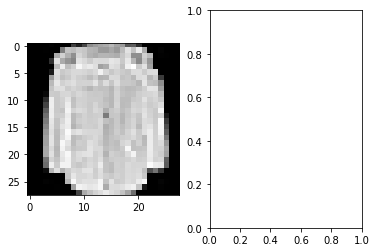

In [9]:
ind = 0
for i in range(len(batch_images1)):
    plt.subplot(121)
    plt.imshow(batch_images1[i].reshape(28,28),cmap="gray")
    plt.subplot(122)
    plt.imshow(batch_images2[i].reshape(28,28),cmap="gray")
    plt.show()


# Training

In [10]:
epochlosses = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, pad

Train: [0/60000 (0%)]	Loss: 0.493470
Epoch: 1/20. Train set: Average loss: 0.2569
Epoch: 1/20. Validation set: Average loss: 0.2096
Train: [0/60000 (0%)]	Loss: 0.199645
Epoch: 2/20. Train set: Average loss: 0.1771
Epoch: 2/20. Validation set: Average loss: 0.1721
Train: [0/60000 (0%)]	Loss: 0.136663
Epoch: 3/20. Train set: Average loss: 0.1471
Epoch: 3/20. Validation set: Average loss: 0.1540
Train: [0/60000 (0%)]	Loss: 0.099195
Epoch: 4/20. Train set: Average loss: 0.1282
Epoch: 4/20. Validation set: Average loss: 0.1474
Train: [0/60000 (0%)]	Loss: 0.111421
Epoch: 5/20. Train set: Average loss: 0.1142
Epoch: 5/20. Validation set: Average loss: 0.1431
Train: [0/60000 (0%)]	Loss: 0.106934
Epoch: 6/20. Train set: Average loss: 0.1032
Epoch: 6/20. Validation set: Average loss: 0.1390
Train: [0/60000 (0%)]	Loss: 0.066613
Epoch: 7/20. Train set: Average loss: 0.0910
Epoch: 7/20. Validation set: Average loss: 0.1373
Train: [0/60000 (0%)]	Loss: 0.084631
Epoch: 8/20. Train set: Average loss: 0

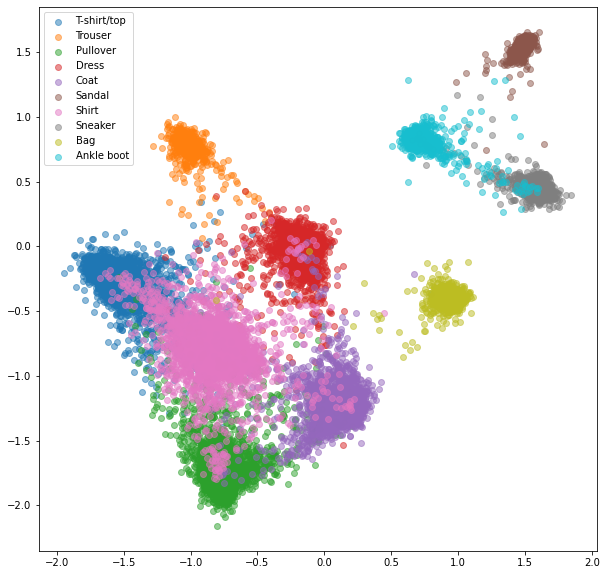

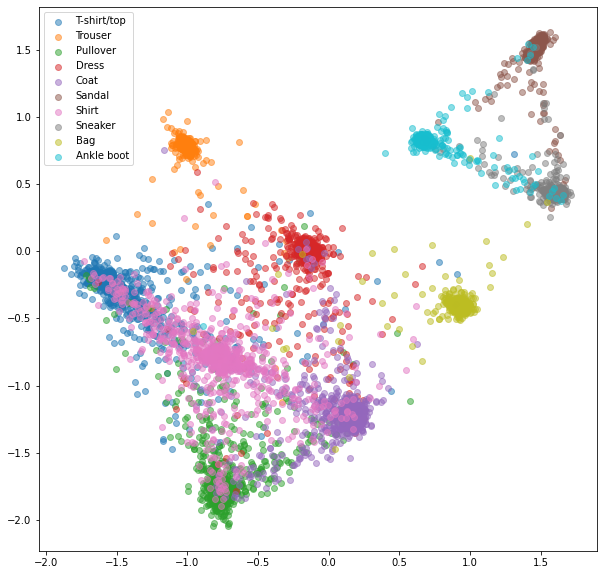

In [15]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

In [19]:
torch.save(model.state_dict(),"siamese_MNIST")

In [20]:
model.load_state_dict(torch.load("siamese_MNIST"))

<All keys matched successfully>

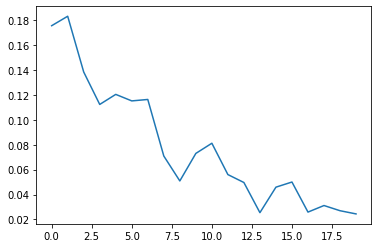

In [16]:
import matplotlib.pyplot as plt 
epochs = []
losses = []
for epoch,loss in epochlosses:
    epochs.append(epoch)
    losses.append(loss[-1])
plt.plot(epochs,losses)
plt.show()


# Results

In [22]:

with torch.no_grad():
        model.eval()
        difference_coeffs = np.zeros((len(online_test_loader.dataset), 2))
        k=0
        for batch_idx, (data, target) in enumerate(online_test_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            images0 = data[0]
            images1 = data[1]
            img0embeddings = model.get_embedding(images0).data.cpu().numpy()
            img1embeddings = model.get_embedding(images1).data.cpu().numpy()
            diff = np.array([])

            #for every image set in the batch
            for i in range(len(img0embeddings)):
                dist = np.square(img0embeddings[i][0]-img1embeddings[i][0]) + np.square(img0embeddings[i][1]-img1embeddings[i][1]) 
                dist_tar = np.array([dist,int(target[i])])
                diff = np.append(diff,dist_tar)
            
            diff = np.reshape(diff, (-1, 2))
            difference_coeffs[k:k+len(images0)] = diff
            k += len(images0)
            
            

IndexError: tuple index out of range

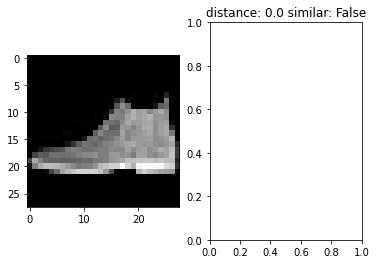

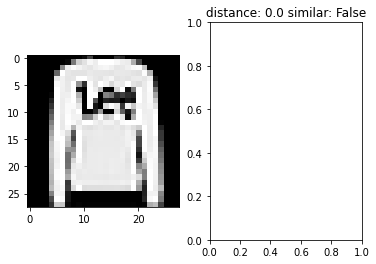

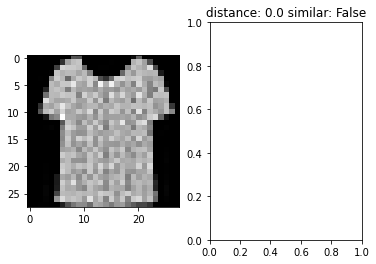

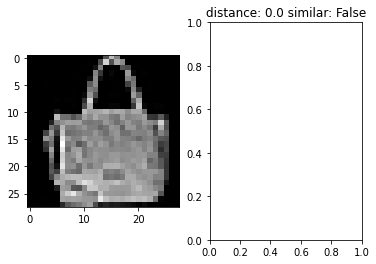

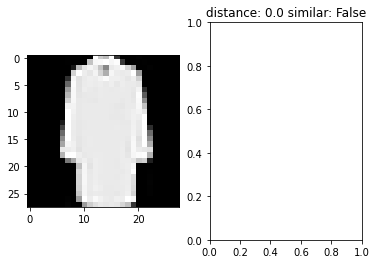

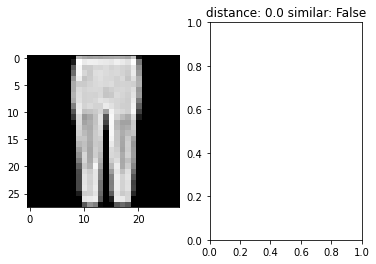

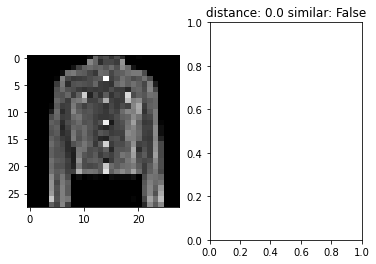

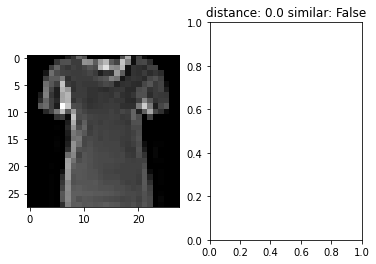

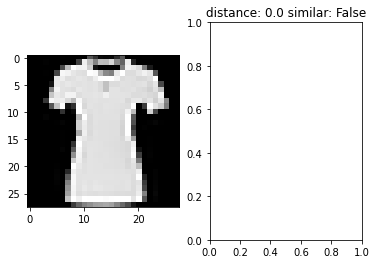

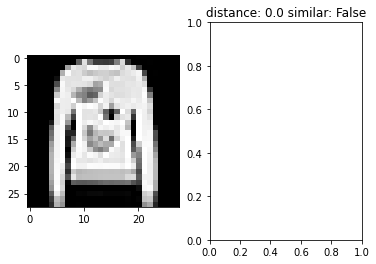

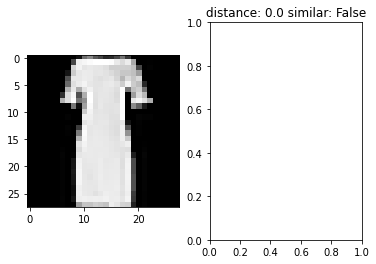

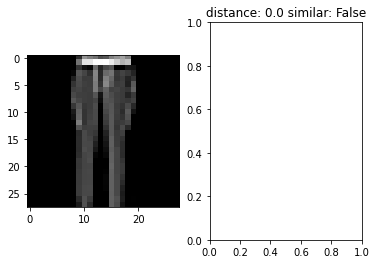

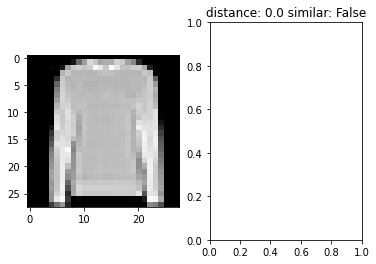

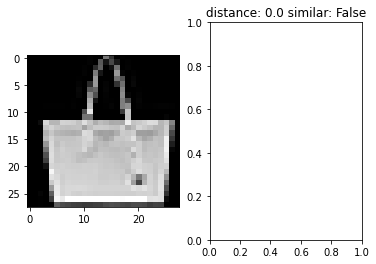

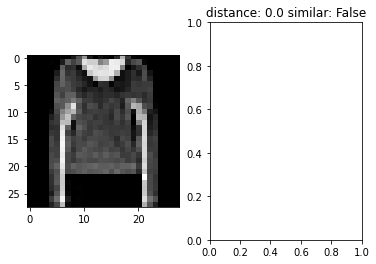

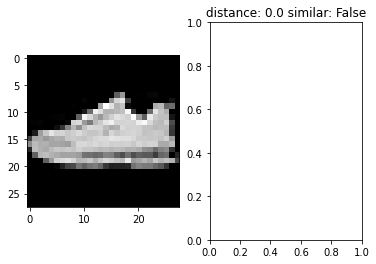

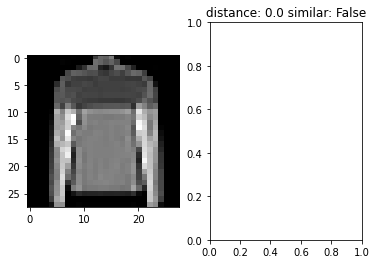

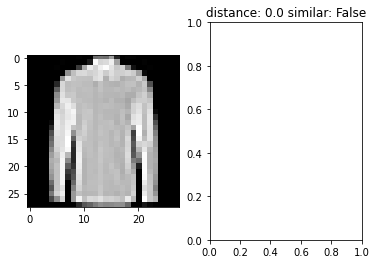

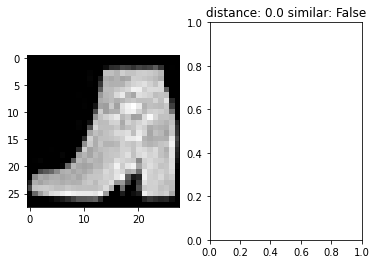

In [25]:
# print(len(difference_coeffs))
for i in range(2):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
   # ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(1000,1001):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(2000,2002):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(3000,3002):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(4000,4002):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(5000,5002):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(6000,6002):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(7000,7002):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(8000,8002):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(9000,9002):
    sample = online_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    #ax2.imshow(sample[0][1].reshape(28,28),"gray")




# Visualize Predictions
Based on our results, we can set a thresold for distance i.e 0.5 for which, 
similar images will have the siamese distance < 0.5 and different ones will give a greater distance

In [26]:
distances = difference_coeffs[:,0]
targets = difference_coeffs[:,1]
print(distances.shape)
print(targets.shape)

(10000,)
(10000,)


In [27]:
threshold = 0.5

In [28]:
predictions = np.array([])
for x in distances:
    if(x < threshold):
        predictions = np.append(predictions,1.0)
    else:
        predictions = np.append(predictions,0.0)
accuracy = len(predictions[predictions == 1])/len(predictions)
print(accuracy)

1.0


In [29]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(targets, predictions)

<AxesSubplot:>

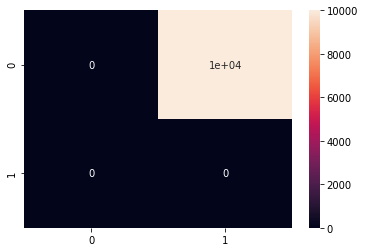

In [30]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [ ]:
print(model)